# Analysis of Review Time vs Retention and Rating

This notebook explores how real review durations (ms) correlate with FSRS-estimated retrievability and the ratings provided by the user.

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm

# Add src to path
sys.path.append(os.path.abspath("../src"))

from fsrs import Card, Scheduler

from anki_utils import get_review_history_stats, infer_review_weights, load_anki_history
from simulate_fsrs import RustOptimizer, run_simulation
from simulation_config import SeededData, SimulationConfig

# Configuration
SEED_HISTORY = "../collection.anki2"
DECK_CONFIG = "ChineseReading"

if not os.path.exists(SEED_HISTORY):
    raise FileNotFoundError(f"{SEED_HISTORY} not found!")

/home/acbraith/projects/fsrs_experiments/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Data Loading and FSRS Fitting
We load the history for the specified deck config and fit FSRS-6 parameters to get accurate retrievability estimates.

In [2]:
print(f"Loading history for {DECK_CONFIG}...")
logs, last_rev = load_anki_history(SEED_HISTORY, deck_config_name=DECK_CONFIG)
flat_logs = [log for card_logs in logs.values() for log in card_logs]

print(f"Fitting FSRS-6 parameters on {len(flat_logs)} reviews...")
optimizer = RustOptimizer(flat_logs)
fitted_params = tuple(optimizer.compute_optimal_parameters())
print(f"Fitted params: {fitted_params}")

# Pre-calculate card states for seeding
print("Pre-calculating initial card states (replaying history)...")
scheduler = Scheduler(parameters=fitted_params)
true_cards = {}
sys_cards = {}

for cid, card_logs in logs.items():
    true_cards[cid] = scheduler.reschedule_card(Card(card_id=cid), card_logs)
    sys_cards[cid] = scheduler.reschedule_card(Card(card_id=cid), card_logs)

weights = infer_review_weights(logs)

seeded_data = SeededData(
    logs=logs,
    last_rev=last_rev,
    true_cards=true_cards,
    sys_cards=sys_cards,
    weights=weights,
)
print("Seeding complete.")

Loading history for ChineseReading...
Anki database version 18 detected.
Querying reviews for 1 matching decks...
Successfully loaded 150922 reviews for 13641 cards.
Review date range: 2019-02-09 to 2026-01-28
Fitting FSRS-6 parameters on 150922 reviews...
Fitted params: (0.002772196661680937, 1.5849497318267822, 15.689563751220703, 15.689563751220703, 6.413300037384033, 0.8334000110626221, 3.019399881362915, 0.0010000000474974513, 1.8722000122070312, 0.16660000383853912, 0.7960000038146973, 1.4835000038146973, 0.061400000005960464, 0.2628999948501587, 1.648300051689148, 0.6014000177383423, 1.8729000091552734, 0.5425000190734863, 0.09120000153779984, 0.0658000037074089, 0.1542000025510788)
Pre-calculating initial card states (replaying history)...
Seeding complete.


## 2. Replaying History
We replay the history using the fitted parameters to calculate the estimated retrievability at the moment of each review.

In [3]:
stats = get_review_history_stats(logs, fitted_params)
df = pd.DataFrame(stats)
df = df.dropna(subset=["duration"])
assert (df["duration"] == 0).sum() == 0
# Convert duration from ms to seconds for easier reading
df["duration_sec"] = df["duration"] / 1000.0
df["is_new_card"] = df["stability"] == 0
df.head()

,card_id,retention,rating,duration,stability,difficulty,elapsed_days,duration_sec,is_new_card
0,1393817670651,0.519463,4,4539.0,0.000000,3.259772,0.000000,4.539,True
1,1393817670651,0.973855,4,4309.0,15.689564,1.000000,3.916837,4.309,False
2,1393817670651,0.953923,4,5875.0,41.090810,1.000000,15.162529,5.875,False
3,1393817670651,0.958303,4,5133.0,141.756947,1.000000,46.437872,5.133,False
4,1393817670651,0.947385,3,2822.0,396.993225,1.000000,170.931361,2.822,False


## Correlation Matrix
Checking the linear relationship strength between variables.

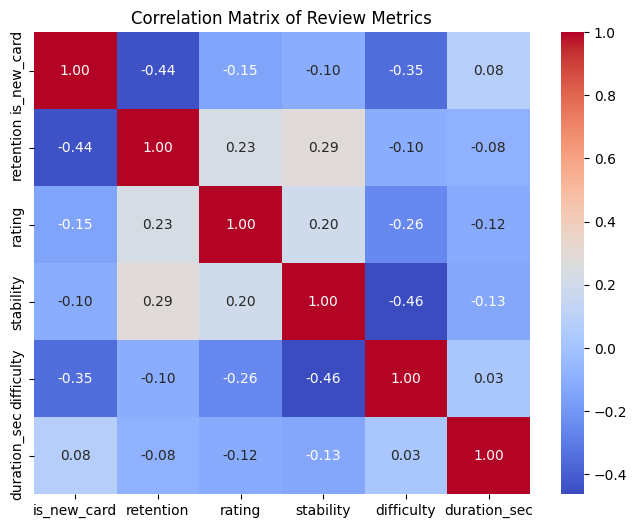

In [4]:
corr = df[
    ["is_new_card", "retention", "rating", "stability", "difficulty", "duration_sec"]
].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Review Metrics")
plt.show()

## Review Time Estimation
Review time is not constant; it can be more expensive to review certain types of cards.

We'll fit a linear model to give us more accurate estimates of review time.

Optimal Alpha: 0.072545
R-squared: 0.0310
--- Coefficients ---
is_new_card: 0.1629
retention: -0.0619
rating: -0.5374
stability: -0.7055
difficulty: -0.1848


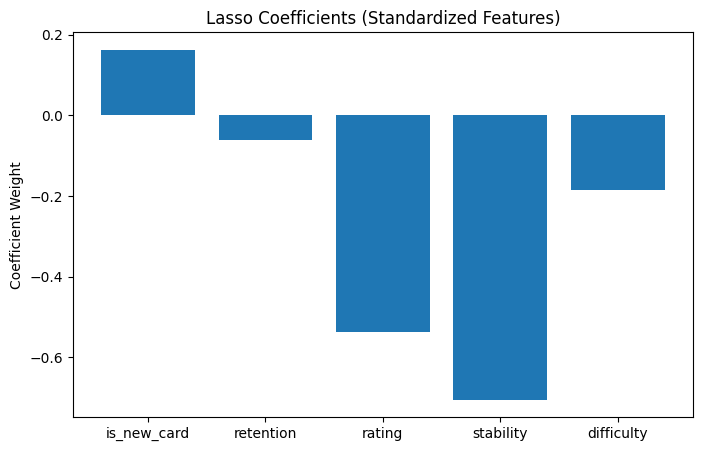

In [5]:
# Prepare features and target
features = ["is_new_card", "retention", "rating", "stability", "difficulty"]
target = "duration_sec"
X = df[features].values
y = df[target].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Lasso with Cross-Validation to select alpha
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

print(f"Optimal Alpha: {lasso.alpha_:.6f}")
print(f"R-squared: {lasso.score(X_scaled, y):.4f}")
print("--- Coefficients ---")
for feat, coef in zip(features, lasso.coef_, strict=False):
    print(f"{feat}: {coef:.4f}")

plt.figure(figsize=(8, 5))
plt.bar(features, lasso.coef_)
plt.title("Lasso Coefficients (Standardized Features)")
plt.ylabel("Coefficient Weight")
plt.show()

## Optimal Retention with Review Time Estimates
Current optimal retention assumes all reviews are equal. We can now estimate the true cost (in time) of a review.

Let's run simulations using these estimates for review times based on card state at time of review to see the impact this has on optimal retention.

In [6]:
import numpy as np

from simulate_fsrs import (
    calculate_expected_d0,
)

# Calculate baseline features for new cards (consistent with get_review_history_stats)
w_first = weights["first"]
prob_first_success = 1.0 - w_first[0]
expected_d0 = calculate_expected_d0(w_first, fitted_params)


def lasso_time_estimator(card, rating, current_date):
    # Use Card attributes, handling None for new cards
    s = card.stability

    if s is None or s == 0:
        # Brand new card features
        ret = prob_first_success
        s_feat = 0.0
        d_feat = expected_d0
        is_new = True
    else:
        ret = scheduler.get_card_retrievability(card, current_date)
        s_feat = s
        d_feat = card.difficulty
        is_new = False

    features = np.array([[int(is_new), ret, int(rating), s_feat, d_feat]])
    features_scaled = scaler.transform(features)
    pred_sec = lasso.predict(features_scaled)[0]
    return max(0.5, pred_sec)  # Floor at 0.5s

In [7]:
import concurrent.futures

daily_budget_sec = 30 * 60
mean_duration_sec = df["duration_sec"].mean()

retentions = [0.1, 0.3, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


def constant_time_estimator(card, rating, current_date):
    return mean_duration_sec


def run_sim_task(args):
    ret, estimator_type = args
    if estimator_type == "lasso":
        estimator = lasso_time_estimator
    else:
        estimator = constant_time_estimator

    config = SimulationConfig(
        n_days=180,
        retention=str(ret),
        review_limit=None,
        new_limit=None,
        time_limit=daily_budget_sec,
        time_estimator=estimator,
        verbose=False,
    )

    _, _, metrics = run_simulation(
        config,
        seeded_data=seeded_data,
        ground_truth=fitted_params,
        initial_params=fitted_params,
    )
    return metrics


print(f"Running {len(retentions) * 2} simulations with ProcessPoolExecutor...")

tasks = [(ret, "constant") for ret in retentions] + [
    (ret, "lasso") for ret in retentions
]

with concurrent.futures.ProcessPoolExecutor() as executor:
    future_to_index = {
        executor.submit(run_sim_task, task): i for i, task in enumerate(tasks)
    }
    all_results = [None] * len(tasks)

    completed = concurrent.futures.as_completed(future_to_index)
    for future in tqdm(completed, total=len(tasks), desc="Simulating"):
        index = future_to_index[future]
        all_results[index] = future.result()

results_constant = all_results[: len(retentions)]
results_lasso = all_results[len(retentions) :]

print("Simulations complete.")

100%|██████████| 10/10 [14:37<00:00, 87.73s/it]


In [8]:
# 1. Determine N_max (baseline population size)
max_cards = max(m["card_count"] for m in results_lasso + results_constant)

# 2. Baseline retention for unseen cards
r_baseline = prob_first_success


def get_adjusted_total(metrics_list, max_n, r_base):
    adjusted = []
    for m in metrics_list:
        # Current sum of retention for studied cards
        current_total = m["total_retention"]
        # Add hypothetical retention for cards we "could have" studied
        missing_cards = max_n - m["card_count"]
        # Ensure we don't subtract if a run somehow exceeded the max (unlikely)
        padding = max(0, missing_cards) * r_base
        adjusted.append(current_total + padding)
    return adjusted


adj_results_constant = get_adjusted_total(results_constant, max_cards, r_baseline)
adj_results_lasso = get_adjusted_total(results_lasso, max_cards, r_baseline)

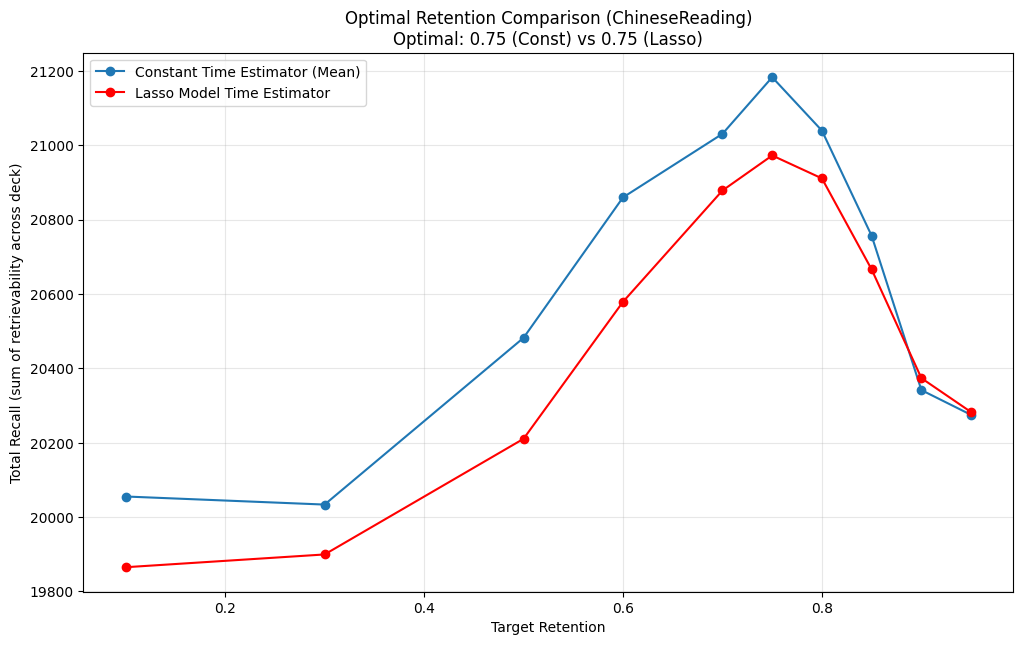

In [9]:
plt.figure(figsize=(12, 7))
plt.plot(
    retentions, adj_results_constant, marker="o", label="Constant Time Estimator (Mean)"
)
plt.plot(
    retentions,
    adj_results_lasso,
    marker="o",
    color="red",
    label="Lasso Model Time Estimator",
)

# Highlight the max recall points
opt_ret_const = retentions[np.argmax(adj_results_constant)]
opt_ret_lasso = retentions[np.argmax(adj_results_lasso)]

plt.title(
    f"Optimal Retention Comparison (ChineseReading)\n"
    f"Optimal: {opt_ret_const} (Const) vs {opt_ret_lasso} (Lasso)"
)
plt.xlabel("Target Retention")
plt.ylabel("Total Recall (sum of retrievability across deck)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()